Notes:
- passing 'bikes' into the YELP and FSQR results at their production in yelp_foursquare_EDA.ipynb would remove the need to merge 'bikes' now
    - This is would allow results to be loaded in and processed without needing to know the city they are from
- a multivariate regression attempting to use poi characteristics to predict how many bikes should be placed at a location should be explored
    - could provide valuable insight for bike rental companies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
import statsmodels.api as sm

Build a regression model.

In [2]:
# load data
results_FSQR = pd.read_csv('../data/POI_results/pois_FSQR.csv')
results_YELP = pd.read_csv('../data/POI_results/pois_YELP.csv')
palmaBikes = pd.read_csv('../data/Networks/PalmaBikes.csv')

In [3]:
# standardize foursquare results rating to the yelp 5 point system
results_FSQR['rating'] = results_FSQR['rating'] / 2

# combine number of bikes with query results
full_results = results_FSQR.merge(palmaBikes, left_on = 'station_id', right_on = 'station_id')

### Foursquare data

Attempt to predict average distance to a poi by number of bikes (Palma)

In [4]:
# prepare data
X_prep = full_results[['distance', 'station_id']].groupby('station_id').mean()
y_prep = full_results[['bikes', 'station_id']].groupby('station_id').median()

# set variables
X = X_prep['distance']
y = y_prep['bikes']

(array([2., 4., 5., 4., 5., 3., 6., 1., 2., 2., 0., 1., 1., 1.]),
 array([ 93.9       , 129.85714286, 165.81428571, 201.77142857,
        237.72857143, 273.68571429, 309.64285714, 345.6       ,
        381.55714286, 417.51428571, 453.47142857, 489.42857143,
        525.38571429, 561.34285714, 597.3       ]),
 <BarContainer object of 14 artists>)

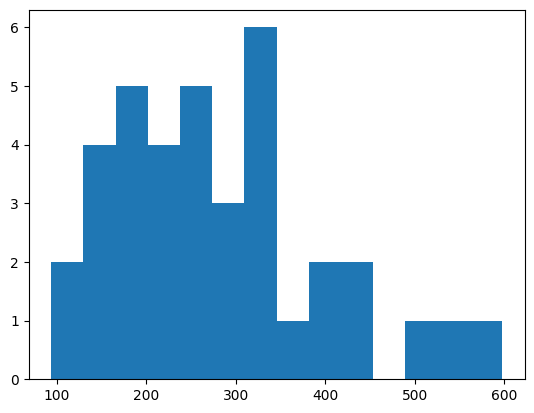

In [5]:
# check for normal distribution
plt.hist(X, bins = 14)

Not very normally distributed, but I'll try modelling:

In [6]:
X = sm.add_constant(X) # adding a constant
lin_reg = sm.OLS(y,X)

In [7]:
model = lin_reg.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  bikes   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                 -0.016
Method:                 Least Squares   F-statistic:                    0.4388
Date:                Tue, 28 Feb 2023   Prob (F-statistic):              0.512
Time:                        12:37:03   Log-Likelihood:                -109.59
No. Observations:                  37   AIC:                             223.2
Df Residuals:                      35   BIC:                             226.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         16.9260      2.047      8.271      0.000      12.771      21.081
distance      -0.0045      0.007     -0.662      0.512      -0.018       0.009
==============================================================================
Omnibus:                        2.759   Durbin-Watson:                   2.429
Prob(Omnibus):                  0.252   Jarque-Bera (JB):                1.580
Skew:                           0.370   Prob(JB):                        0.454
Kurtosis:                       3.690   Cond. No.                         781.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

R-Squared is poor, P-Value is far too high, and additional tests all point to the data not fitting the assumptions for linear regression. Since the distribution of the data appeared to be skewed left, I will try a sqrt transformation then model again to see if better results can be gained.

In [8]:
# set variables
X = np.sqrt(X_prep['distance'])
y = y_prep['bikes']

(array([2., 0., 4., 5., 4., 4., 2., 6., 3., 2., 2., 0., 2., 1.]),
 array([ 9.69020124, 10.74373842, 11.7972756 , 12.85081278, 13.90434996,
        14.95788714, 16.01142432, 17.0649615 , 18.11849868, 19.17203586,
        20.22557304, 21.27911022, 22.3326474 , 23.38618459, 24.43972177]),
 <BarContainer object of 14 artists>)

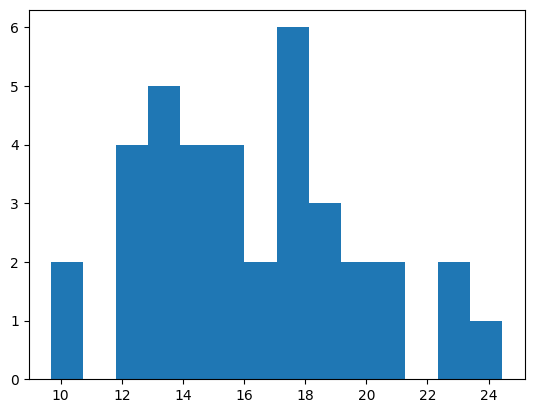

In [9]:
# check for normal distribution
plt.hist(X, bins = 14)

Distribution appears slightly more normal, but still too bimodal.

In [10]:
X = sm.add_constant(X) # adding a constant
lin_reg = sm.OLS(y,X)

In [11]:
model = lin_reg.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  bikes   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                 -0.011
Method:                 Least Squares   F-statistic:                    0.6205
Date:                Tue, 28 Feb 2023   Prob (F-statistic):              0.436
Time:                        12:37:03   Log-Likelihood:                -109.50
No. Observations:                  37   AIC:                             223.0
Df Residuals:                      35   BIC:                             226.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         18.6386      3.843      4.850      0.000      10.836      26.441
distance      -0.1815      0.230     -0.788      0.436      -0.649       0.286
==============================================================================
Omnibus:                        2.667   Durbin-Watson:                   2.412
Prob(Omnibus):                  0.264   Jarque-Bera (JB):                1.504
Skew:                           0.355   Prob(JB):                        0.471
Kurtosis:                       3.687   Cond. No.                         81.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Sqrt transformation yielded a better model, but not by a high enough margin to make the model useful.

# Stretch

How can you turn the regression model into a classification model?